In [1]:
### Imports ###

include("../src/QComp.jl")
using .QComp

using Yao
using YaoPlots
using Plots
default(lw=2, ms=5, palette=:Set2_8)
using LinearAlgebra
using Random
using Optimisers

#### Examples: run one cell

In [2]:
### Example: random vs uniform states ###

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 20
states1 = [rand_state(n) for i=1:n_samples*2]
states2 = [uniform_state(n) for i=1:n_samples*2]

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = Data(tr_states, tr_labels);
d2 = Data(te_states, te_labels);

In [2]:
### Example: forrelated vs random states ###

using JLD2
using NPZ

data = load("../data/old/forr_rand_fns_n4.jld2")

forr_f = data["single_stored_object"][1]
rand_f = data["single_stored_object"][2]

forr_batch, forr_samples, forr_vec = size(forr_f, 1), size(forr_f[1], 1), size(forr_f[1][1], 1)
rand_batch, rand_samples, rand_vec = size(rand_f, 1), size(rand_f[1], 1), size(rand_f[1][1], 1)

new_forr_f = zeros(Float64, forr_batch, forr_samples, forr_vec)
new_rand_f = zeros(Float64, rand_batch, rand_samples, rand_vec)

for i in 1:forr_batch
    for j in 1:forr_samples
        new_forr_f[i, j, :] = forr_f[i][j]
        new_rand_f[i, j, :] = rand_f[i][j]
    end
end

####### Change to Int -1, 1 ########
new_forr_f = trunc.(Int64, new_forr_f)
new_rand_f = trunc.(Int64, new_rand_f)
forr_f[12][1][:] ≈ new_forr_f[12,1,:] ? println("Loading data: successful") : println("Loading data: failed")
####################################

seed = 1234 # set seed for reproducibility
Random.seed!(seed)

n = 4 # preferably a power of 2

n_samples = 20
states1 = Vector{NTuple{2, ArrayReg}}(undef, 2*n_samples)
states2 = Vector{NTuple{2, ArrayReg}}(undef, 2*n_samples)
psi_zero = zero_state(n)
# psi_zero = zero_state(trunc(Int, log2(n)))
for i in 1:2*n_samples
    states1[i] = (copy(psi_zero) |> circ_hypergraph_state(new_forr_f[i, 1, :]), copy(psi_zero) |> circ_hypergraph_state(new_forr_f[i, 2, :]))
    states2[i] = (copy(psi_zero) |> circ_hypergraph_state(new_rand_f[i, 1, :]), copy(psi_zero) |> circ_hypergraph_state(new_rand_f[i, 2, :]))
end
states1[1][1].state ≈ normalize(new_forr_f[1, 1, :]) ? println("Preparation hypergraph states: successful") : println("Preparation hypergraph states: failed")

# train
tr_states = vcat([states1[1:n_samples], states2[1:n_samples]]...)
tr_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# test
te_states = vcat([states1[n_samples+1:n_samples*2], states2[n_samples+1:n_samples*2]]...)
te_labels = vcat([repeat([1], n_samples), repeat([-1], n_samples)]...)

# structures
d1 = DataSiamese(tr_states, tr_labels);
d2 = DataSiamese(te_states, te_labels);

Loading data: successful
Preparation hypergraph states: successful


##### Tests

In [3]:
# res, circ = swap_test(zero_state(2) |> push!(chain(2), put(1=>H)), zero_state(2))
state1 = rand_state(4)
state2 = rand_state(4)

res = swap_test(state1, state2)
res_des = destructive_swap_test(state1, state2)

println(abs2(dot(state1.state, state2.state)))
println(res)
println(res_des)

# YaoPlots.plot(circ_swap_test(3))

0.08387112036511393
0.08400000000000002
0.11599999999999999


In [201]:
state1 = rand_state(4)
state2 = rand_state(4)
circ = p.circ
dispatch!(circ, p.params)
println(state1.state)
println(state2.state)
println(abs2(dot(state1.state, state2.state)))
state1_transformed = copy(state1) |> circ
state2_transformed = copy(state2) |> circ
println(state1_transformed.state)
println(state2_transformed.state)
println(abs2(dot(state1_transformed.state, state2_transformed.state)))
loss = destructive_swap_test(state1_transformed, state2_transformed; nshots=100000)
println(loss)

ComplexF64[-0.28985501441016004 - 0.07706375315124674im; -0.09672323308824864 - 0.19048600044993796im; 0.25187693344992074 - 0.0863152701528849im; 0.14478310481442602 - 0.07994915739042678im; -0.18007359339167145 - 0.10660309671723532im; 0.054693609276148275 + 0.08815663696058193im; 0.19427873963790052 + 0.13676667052119204im; -0.3302468319795808 - 0.2626123789180961im; -0.30491327961549874 + 0.032157739430125im; 0.036185589931365454 + 0.11308009238779193im; 0.19417076965440264 + 0.016815740480158096im; 0.004673503635813931 + 0.05408052592500843im; -0.12528995452949432 + 0.15627511605252414im; 0.43828729040305825 - 0.08396973579618168im; 0.03246977863895189 + 0.2330336355276751im; -0.028606677228375725 - 0.18069184895439133im;;]
ComplexF64[0.00831165774957795 + 0.021417472545289563im; -0.07698612378639409 - 0.2429762871254898im; 0.16457440758064784 + 0.09354845230328157im; 0.3359896540557572 - 0.10240880252191002im; 0.08990993181675193 - 0.17592307049266662im; -0.31393425208973713 + 0.

0.13582000000000005

In [4]:
tmp_state = rand_state(4)
println(von_neumann_entropy(tmp_state, 1))

tmp_state_transformed = copy(tmp_state) |> chain(4, put(1=>H), control(1, 2=>X))
println(von_neumann_entropy(tmp_state_transformed, 1))

0.634697620914392
0.5826058144422143


In [396]:
matblock(circ_unitary)

matblock(...)

In [428]:
circ_unitary = matblock(rand_unitary(4))
# circ_unitary = chain(2, put(1=>H), control(1, 2=>X))

# psi1 = normalize!(ArrayReg(bit"00"))
# psi2 = normalize!(ArrayReg(bit"01") + ArrayReg(bit"11"))
psi1 = rand_state(2)
psi2 = rand_state(2)
psi1_transformed = copy(psi1) |> circ_unitary
psi2_transformed = copy(psi2) |> circ_unitary

println(psi1.state)
println(psi2.state)
println(psi1_transformed.state)
println(psi2_transformed.state)

println(abs2(dot(psi1.state, psi2.state)))
println(abs2(dot(psi1_transformed.state, psi2_transformed.state)))

println(abs(von_neumann_entropy(psi1, 1) - von_neumann_entropy(psi2, 1)))
println(abs(von_neumann_entropy(psi1_transformed, 1) - von_neumann_entropy(psi2_transformed, 1)))

ComplexF64[0.1371279843758014 + 0.024271205451569067im; -0.09877951709451079 + 0.2678067067682725im; 0.7819092739015049 + 0.07242763444583647im; -0.46689964490182767 + 0.2539800111138955im;;]
ComplexF64[-0.3011423383681282 - 0.16243543794162302im; -0.2715460944837278 - 0.4199741005306793im; 0.22526007103207446 - 0.09564762541392974im; -0.0832985416802369 + 0.7523186021242712im;;]
ComplexF64[0.3448088671095588 - 0.4215652065843898im; -0.4016312337354541 - 0.0736181819383317im; -0.3423736452596712 + 0.34956111334319373im; -0.3771352376198069 - 0.39372409724531554im;;]
ComplexF64[-0.17274605842993015 - 0.008318926166297175im; -0.6834263212635622 + 0.6752985897224848im; -0.19714172769898092 + 0.0696784158427614im; 0.03021702613687599 - 0.048547520887135875im;;]
0.17563681818416405
0.17563681818416382
0.15700229908355082
0.4645350477584546


In [3]:
ansatz = conv_SU4 # conv_Ry, conv_Ry2, conv_SU4
circ = build_QCNN(n, ansatz=ansatz)
# p = GenericParams(n=n, circ=circ)
p = InvariantParams(n=n, circ=circ, ansatz=ansatz)
initialize_params(p);

println(p.n)
println(p.n_layers)
println(p.params)
println(length(p.params))
# println(p.circ)

4
2
[2.0899466718831397, 2.4673738355113226, 5.40742230428725, 5.508094280034202, 2.7990185950103084, 1.6132278420279198, 4.539448360137592, 1.475127918662063, 5.280875616828383, 2.684074352934397, 1.7241131532149172, 0.11537963547086738, 1.9459168811784542, 1.8391613074127038, 2.162651889312506, 1.7643556269794376, 3.639919843983497, 2.612703733074466, 4.1181846081013616, 4.833761346875108, 4.51077668495883, 4.474698074285555, 0.010722906538659874, 4.0077806221378225, 0.24124583586000833, 2.485099665300055, 5.2431484912881565, 1.6765128814731192, 4.438585383439919, 1.5913794522058842]
30


#### Model parameters

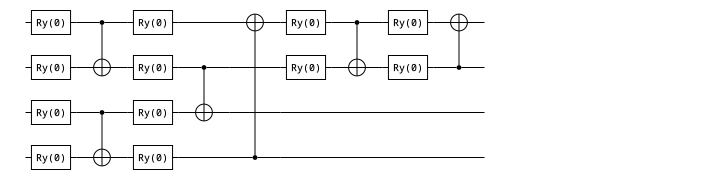

In [3]:
iters = 10 # number of iterations
lr = 0.05  # learning rate. Start with lr=0.1. Reduce to (e.g. lr=0.01) if optimisation is not smooth.
optim = ADAM(lr) # Descent(lr) # See https://fluxml.ai/Optimisers.jl/dev/api/#Optimisation-Rules for different optimisers.
sig = true # use the sigmoid activation function
ansatz = conv_Ry # conv_Ry, conv_Ry2, conv_SU4

circ = build_QCNN(n, ansatz=ansatz)

p = GenericParams(n=n, circ=circ)
# p = InvariantParams(n=n, circ=circ, ansatz=ansatz)
initialize_params(p);

YaoPlots.plot(circ)

#### Run

In [6]:
params, loss_track, tr_track, te_track, tr_preds, te_preds = train_test_model(d1, d2, p, iters, optim, sig; output=false)

Initial: loss = 0.9768941617229223, tr_acc = 0.625, te_acc = 0.525
Final: loss = 0.9768941617229223, tr_acc = 0.625, te_acc = 0.525


([2.7012374282670644, 3.2668767859903105, 5.167058677116636, -0.5134093838702394, 3.3849477875671568, 4.113401300916349, 4.711172484127379, 5.4200895091374335, 0.9383798913337066, 6.076045598562389, 3.6085808849351744, 4.257799945681906], [0.9768941617229223, 0.9768941617229224, 0.9768941617229223, 0.9768941617229224, 0.9768941617229223, 0.9768941617229223, 0.9768941617229223, 0.9768941617229223, 0.9768941617229224, 0.9768941617229223, 0.9768941617229223], [0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625, 0.625], [0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525, 0.525], Any[0.07796644137536801, 0.07796644137536801, 0.606347592713802, 0.606347592713802, 0.30270972933210816, 0.30270972933210794, 0.0, 0.30270972933210816, 0.9605617437853065, 0.30270972933210794  …  0.07796644137536801, 0.0, 0.0, 0.07796644137536801, 0.0, 0.30270972933210816, 0.07796644137536801, 0.6063475927138022, 0.07796644137536801, 0.07796644137536801], Any[0.3027097293321077,

#### Plot

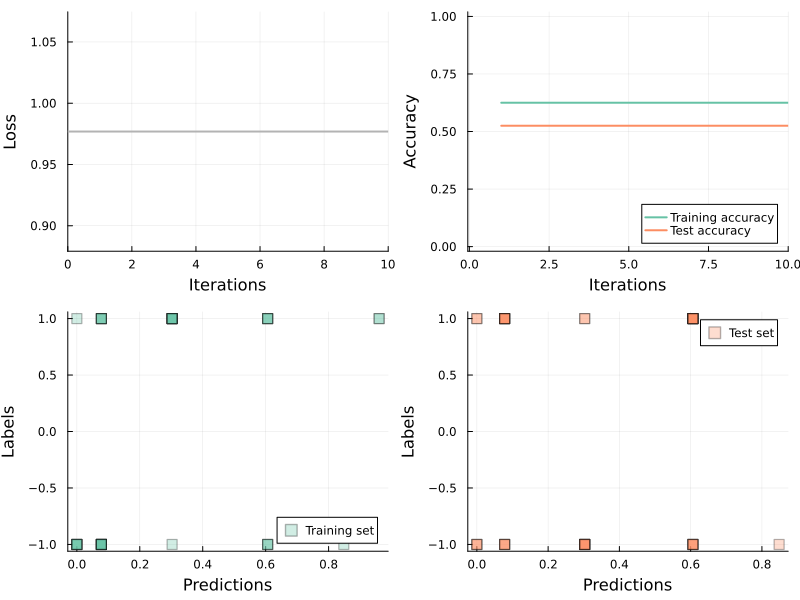

In [22]:
# Loss vs Interations
p1 = Plots.plot(xlim=(0, iters), xlabel="Iterations", ylabel="Loss")
Plots.hline!([loss_track[1]], label=false, c=0, ylim=(0.9loss_track[1], 1.1loss_track[1]))
# Plots.plot!(loss_track, yaxis=:log, label=false, c=0)

# Accuracy vs Interations
p2 = Plots.plot(xlim=(-0.05, iters), ylim=(-0.02, 1.02), xlabel="Iterations", ylabel="Accuracy", legend=:bottomright)
Plots.plot!(tr_track, label="Training accuracy", c=1)
Plots.plot!(te_track, label="Test accuracy", c=2)

# Training labels vs predictions
p3 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(tr_preds, tr_labels, ma=0.3, shape=:rect, label="Training set", c=1)

# Test labels vs predictions
p4 = Plots.scatter(xlabel="Predictions", ylabel="Labels")
Plots.scatter!(te_preds, te_labels, ma=0.3, shape=:rect, label="Test set", c=2)

Plots.plot(p1, p2, p3, p4, layout=(2, 2), size=(800, 600))

In [23]:
savefig("qcsnn_forr_n4_conv_Ry_overlap.pdf")

"/home/stefano/GitRepos/QComp.jl/notebooks/qcsnn_forr_n4_conv_Ry_overlap.pdf"